In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#
#

In [2]:
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy
import math
import random
import scipy
import scipy.optimize as spo
import scipy.special
#import scipy.interpolate
#
import matplotlib as mpl
import matplotlib.dates as mpd
import multiprocessing as mpp

### The Mandelbrot Set
A complex number $c = a + jb$ is a member of the Mandelbrot Set if iterations of the Mandelbrot Generator,

\begin{equation}
P_m: z_{k_1} = z_k^2 + c
\end{equation}

is bounded, or does not tend to, or "escape to" infinity

\begin{equation}
P_m^n < s_0
\end{equation}

where $s_0 = 2.0$ is a common test, but I find that it is insufficient for high resolution. It is possible that I am misinterpreting the criteria, but in the end, we can afford to increase the compute load, which also gives us a broader range of colors and structure in our figure.

Note that the big dark shape(s) in the middle are the elements of the Mandelbrot Set; the colors and fringes are the divergent $z$ values, that are not members of the set.


#### Programmatic Outline:
- **Mandelbrot_element() class:**
  - Base element for pixels in the set.
  - Inputs:
    - c (complex): the proposed member (complex) number.
    - z0 (complex): starting value. This is almost always $z0 = 0$
    - s0 (real): length (magnitude) of stopping value. values such that z*z > s0*s0 are excluded, and iterations are stopped.
    - nits_max: number of iterations to search for convergance.
- **Mandelbrot_Set():**
  - min_, max_, _real, _im: domain of real and imaginary axes to be sampled
  - n_poits: number of points to sample (randomly)
  - (Mandelbrot_element inputs)
  - n_cpu: number of cpu for multi-processing.

- Randomly (uniform) sample the domain of interest
- For each complex value, $c=a + jb$, instantiate and iterate a Mandelbrot_element() object. Record its $c$, $z$, and 'is_in' values.

- Note: The Mandelbrot_element() class is maybe a bit of structural overkill, and might actually introduce compute-expensive overhead, so if performance becomes an issue, consider coding the iteration directly into the Mandelbrot_Set() class.

#### TODO:
- Presently, images are plotted using plt.scatter(); maybe  introduce a smart handling of plt.imshow() ?


In [3]:
class Mandelbrot_element(object):
    def __init__(self, c,z0=0., s0=2.0, nits_max=500):
        #
        c = numpy.complex(c)
        z0 = numpy.complex(z0)
        #
        z=z0
        s0 = numpy.linalg.norm(s0)
        #s0 = s0*s0.conjugate()
        #
        #
        is_member = True
        #
        for n in range(nits_max):
            z = z**2. + c
            if numpy.linalg.norm(z)>s0:
                is_member = False
                break
            #
        #
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})

class Mandelbrot_Set(list):
    def __init__(self, min_real = -2., max_real=1., min_im=-1.2, max_im=1.2, n_points=1e4,
                z0=0., s0=2., nits_max=500, n_cpu=None):
        n_points = int(n_points)
        n_cpu = n_cpu or mpp.cpu_count()
        #
        R_re = random.Random()
        R_im = random.Random()
        CZt = []
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', 'CZt', '__class__')})
        #
        CZt += self.get_mandelbrot_points()
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', 'CZt', '__class__')})
        super(Mandelbrot_Set, self).__init__(CZt)
    #
    def get_mandelbrot_points(self, n_points=None, R_re=None, R_im=None,
                    min_real=None, max_real=None, min_im=None, max_im=None,
                    z0=None, s0=None, nits_max=None, n_cpu = None):
        n_cpu = n_cpu or self.n_cpu
        #
        n_points = n_points or self.n_points
        R_re = R_re or self.R_re
        R_im = R_im or self.R_im
        if z0 is None:
            z0 = self.z0
        s0 = s0 or self.s0
        nits_max = self.nits_max
        #
        if min_real is None:
            min_real = self.min_real
        if max_real is None:
            max_real = self.max_real
        if min_im is None:
            min_im = self.min_im
        if max_im is None:
            max_im = self.max_im
        #
        if n_cpu>1:
            input_prams = {key:val for key,val in locals().items() if not key in ('self', '__class__')}
            #
            input_prams['n_points'] = int(1 + input_prams['n_points']/n_cpu)
            input_prams['n_cpu']=1
            #
            # also, we need to instantiate new Random() objects, since otherwise we pickle over the same
            #  objects, and we get n_cpu duplicates. it is faster to push this to each process, but nominally
            #  we don't get a guarantee that each object is unique, unless we construct a seed key. in the
            #  end, it is just not that expensive to build them here.
            #
            P = mpp.Pool(n_cpu)
            #res = [P.apply_async(self.get_mandelbrot_points, kwds=input_prams) for k in range(n_cpu)]
            res = []
            for k in range(n_cpu):
                input_prams['R_im'] = random.Random()
                input_prams['R_re'] = random.Random()
                res += [P.apply_async(self.get_mandelbrot_points, kwds=input_prams)]
            #
            P.close()
            P.join()
            #
            CZt = []
            for r in res:
                CZt += r.get()
            #
            del res
            del P
            del input_prams
            #
            return CZt
        else:
            CZt = []
            for k in range(n_points):
                #
                c = numpy.complex(R_re.uniform(min_real, max_real), R_im.uniform(min_im, max_im))
                m = Mandelbrot_element(c=c, z0=z0, s0=s0, nits_max=nits_max)
                CZt += [[c, m.z, m.is_member]]
                #
            return CZt
    #
    def plot_mandelbrot(self, fg=None, ax=None, figsize=None, cmap='hot'):
        #
        figsize= figsize or tuple([8,6])
        if ax is None:
            if fg is None:
                fg = plt.figure(figsize=figsize)
                #
            else:
                #
                if isinstance(fg, float) or isinstance(fg, int):
                    fg = int(fg)
                    fg = plt.figure(fg, figsize=figsize)
                #
                else:
                    # it should be a figure object;
                    # set current figure to fg.number
                    plt.figure(fg.number)
                #
            #
            ax = plt.subplot('111')
        #
        #print('*** DEBUG cmap: {}'.format(cmap))
        cm = plt.get_cmap(cmap)
        #
        Zs = numpy.array([numpy.linalg.norm(rw[1]) for rw in self])
        clrs = cm(Zs/max(Zs))
        #
        #
        X = [rw[0].real for rw in M]
        Y = [rw[0].imag for rw in M]
        ax.scatter(X, Y, marker='.', c=clrs)
            
            

#### Test a few Mandelbrot_Element() objects:

In [4]:
# test a few Mantelbrot_element() objects:
ms = [Mandelbrot_element(c=c) for c in [-1., numpy.complex(.5, .5), numpy.complex(-1., .5), 1]]

for m in ms:
    print('** {}, {}'.format(m.z, m.is_member))

** 0j, True
** (3.28515625+1.34375j), False
** (-2.6183929443359375+0.890380859375j), False
** (5+0j), False


#### Find a Mandelbrot Set, and plot all the z-values as well, to show the pretty picture(s)
- setting n_cpu=None will default to using all available processors (mpp.cpu_count() ).
- Then demonstrate a few ways to plot the set.

In [5]:
# instantiate and iterate a Mandelbrot_Set() object:
#
M = Mandelbrot_Set(n_points=1e6, nits_max=100, s0=10., n_cpu=None)
#print('** ', M[0:5])

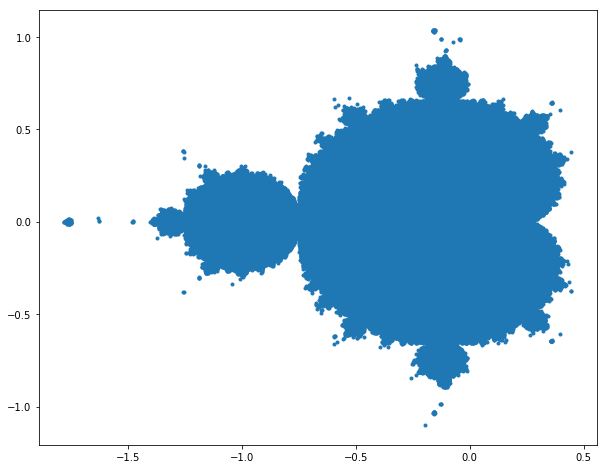

In [6]:
# plot elements in the set:
#
plt.figure(figsize=(10,8))
ax = plt.gca()

X = [rw[0].real for rw in M if rw[2]==True]
Y = [rw[0].imag for rw in M if rw[2]==True]
ax.plot(X, Y, ls='',
       marker='.')

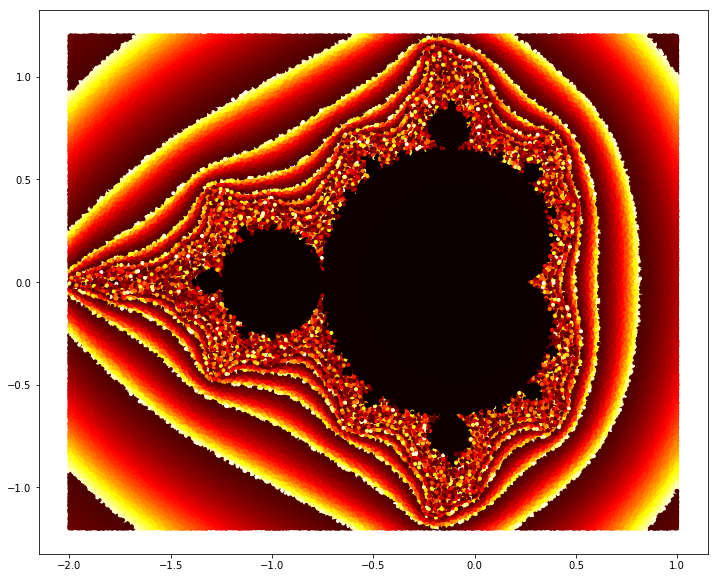

In [7]:
# plot all the elements; show z-value as color.
#

cm = plt.get_cmap('hot')
#
Zs = [numpy.linalg.norm(rw[1]) for rw in M]
clrs = cm(Zs/max(Zs))



plt.figure(figsize=(12,10))
ax = plt.gca()
#
X = [rw[0].real for rw in M]
Y = [rw[0].imag for rw in M]
ax.scatter(X, Y, marker='.', c=clrs)

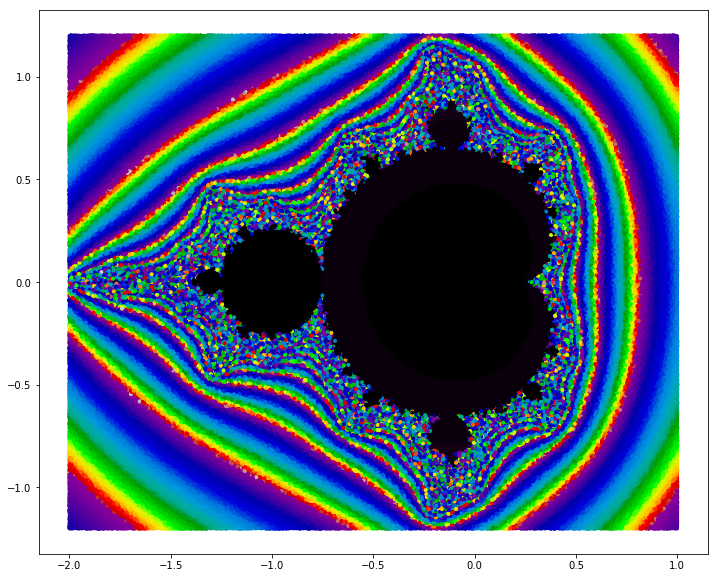

In [11]:
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
M.plot_mandelbrot(ax=ax, cmap='nipy_spectral')

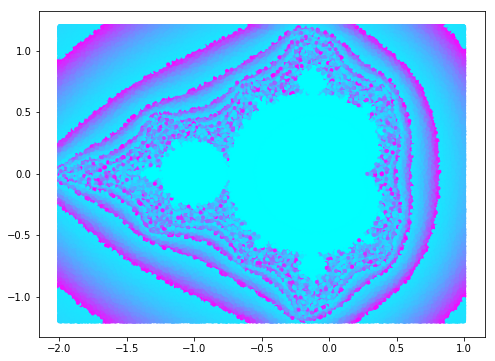

In [9]:
M.plot_mandelbrot(cmap='cool')

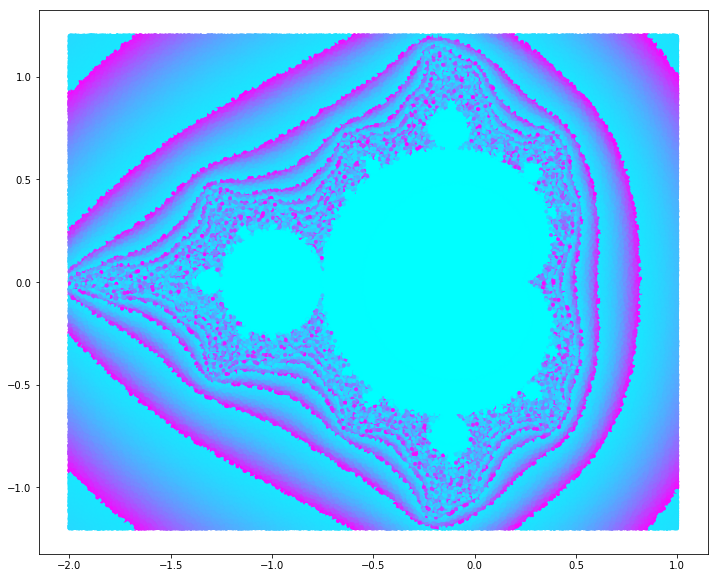

In [10]:
# Try a "cool" colormap:
cm = plt.get_cmap('cool')
#
clrs = cm(Zs/max(Zs))



plt.figure(figsize=(12,10))
ax = plt.gca()
#
X = [rw[0].real for rw in M]
Y = [rw[0].imag for rw in M]
ax.scatter(X, Y, marker='.', c=clrs)